<a href="https://colab.research.google.com/github/chonchuks/Network_Anamoly_Detection/blob/main/Network_Anamoly_Detection_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to the zip file
zip_file_path = '/content/drive/Othercomputers/My PC/models/network_anomaly.zip'

# Define the directory to unzip to
unzip_dir = '/content/data'


# Create the directory if it doesn't exist
os.makedirs(unzip_dir, exist_ok=True)

# Unzip the file to the specified directory
!unzip -q "{zip_file_path}" -d "{unzip_dir}"

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import multiprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, precision_recall_curve
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC  # For SVM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM  # For LSTM
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

**DATA COLLECTION**

In [ ]:
df = pd.read_csv("/content/data/Train.txt",sep=",",names=["duration","protocoltype","service","flag","srcbytes","dstbytes","land", "wrongfragment","urgent","hot","numfailedlogins","loggedin", "numcompromised","rootshell","suattempted","numroot","numfilecreations", "numshells","numaccessfiles","numoutboundcmds","ishostlogin",
"isguestlogin","count","srvcount","serrorrate", "srvserrorrate",
"rerrorrate","srvrerrorrate","samesrvrate", "diffsrvrate", "srvdiffhostrate","dsthostcount","dsthostsrvcount","dsthostsamesrvrate", "dsthostdiffsrvrate","dsthostsamesrcportrate",
"dsthostsrvdiffhostrate","dsthostserrorrate","dsthostsrvserrorrate",
"dsthostrerrorrate","dsthostsrvrerrorrate","attack", "lastflag"])
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


**EDA**

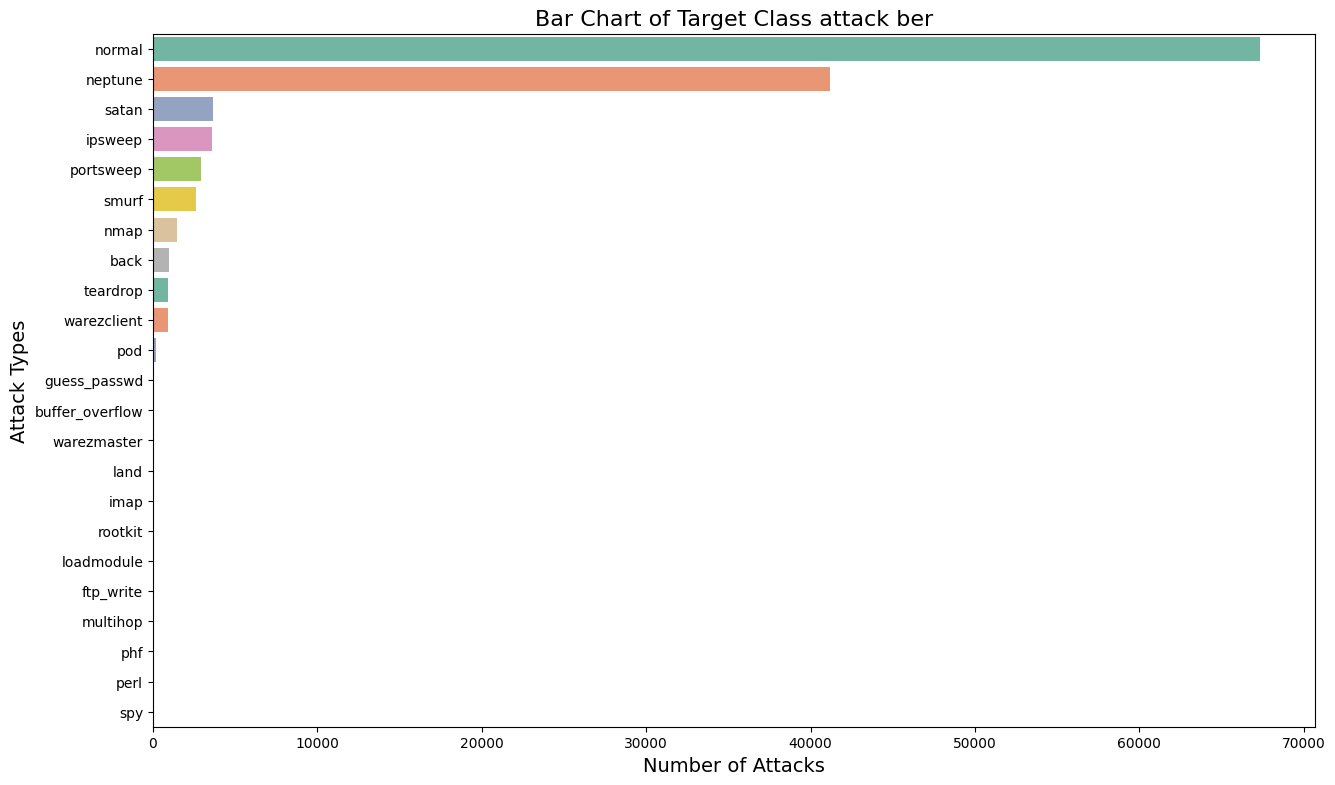

In [ ]:
# df['attack']
def target_col():
  attack_count = df['attack'].value_counts()
  attack_names = attack_count.index.to_list()
  attack_values = attack_count.to_numpy()

  plt.figure(figsize=(15, 9))
  sns.barplot(x=attack_values, y=attack_names, palette='Set2')
  plt.title('Bar Chart of Target Class attack ber', fontsize=16)
  plt.xlabel('Number of Attacks', fontsize=14)
  plt.ylabel('Attack Types', fontsize=14)
  plt.xticks(rotation=0)
  plt.show()
target_col()

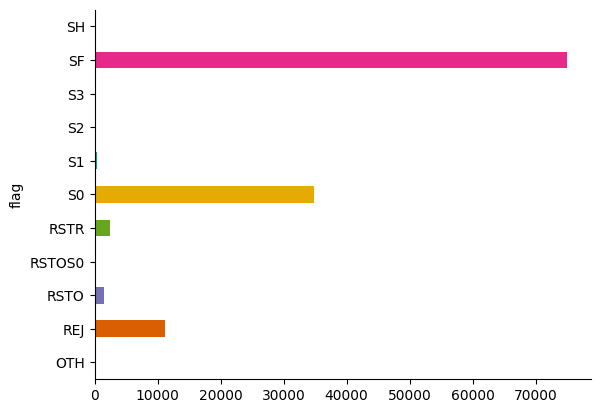

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('flag').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

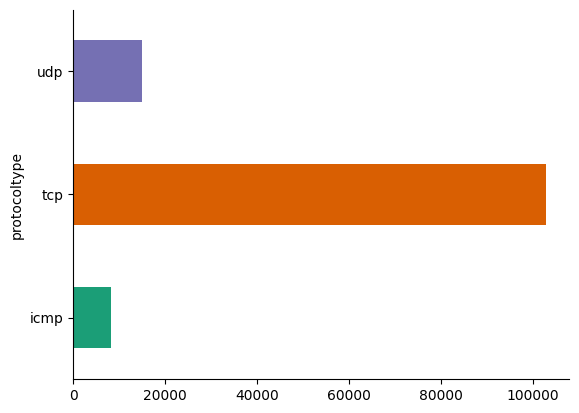

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('protocoltype').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.shape

(125973, 43)

In [ ]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
duration,125973.0,NaN,NaN,NaN,287.14465,2604.51531,0.0,0.0,0.0,0.0,42908.0
protocoltype,125973,3,tcp,102689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
service,125973,70,http,40338,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flag,125973,11,SF,74945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
srcbytes,125973.0,NaN,NaN,NaN,45566.743,5870331.181894,0.0,0.0,44.0,276.0,1379963888.0
dstbytes,125973.0,NaN,NaN,NaN,19779.114421,4021269.151441,0.0,0.0,0.0,516.0,1309937401.0
land,125973.0,NaN,NaN,NaN,0.000198,0.014086,0.0,0.0,0.0,0.0,1.0
wrongfragment,125973.0,NaN,NaN,NaN,0.022687,0.25353,0.0,0.0,0.0,0.0,3.0
urgent,125973.0,NaN,NaN,NaN,0.000111,0.014366,0.0,0.0,0.0,0.0,3.0
hot,125973.0,NaN,NaN,NaN,0.204409,2.149968,0.0,0.0,0.0,0.0,77.0


In [ ]:
df['urgent'].value_counts()

urgent
0    125964
1         5
2         3
3         1
Name: count, dtype: int64

As we can see 'land', 'urgent', 'numfailedlogins', 'numoutboundcmds' have mostly zero values so we can drop these columns.

**DROPING UNNEEDED COLUMNS**

In [ ]:
df.drop(['land','urgent','numfailedlogins','numoutboundcmds'],axis=1,inplace=True)

In [ ]:
df.isna().sum()

duration                  0
protocoltype              0
service                   0
flag                      0
srcbytes                  0
dstbytes                  0
wrongfragment             0
hot                       0
loggedin                  0
numcompromised            0
rootshell                 0
suattempted               0
numroot                   0
numfilecreations          0
numshells                 0
numaccessfiles            0
ishostlogin               0
isguestlogin              0
count                     0
srvcount                  0
serrorrate                0
srvserrorrate             0
rerrorrate                0
srvrerrorrate             0
samesrvrate               0
diffsrvrate               0
srvdiffhostrate           0
dsthostcount              0
dsthostsrvcount           0
dsthostsamesrvrate        0
dsthostdiffsrvrate        0
dsthostsamesrcportrate    0
dsthostsrvdiffhostrate    0
dsthostserrorrate         0
dsthostsrvserrorrate      0
dsthostrerrorrate   

In [ ]:
df.select_dtypes(exclude=[np.number])

,protocoltype,service,flag,attack
0,tcp,ftp_data,SF,normal
1,udp,other,SF,normal
2,tcp,private,S0,neptune
3,tcp,http,SF,normal
4,tcp,http,SF,normal
...,...,...,...,...
125968,tcp,private,S0,neptune
125969,udp,private,SF,normal
125970,tcp,smtp,SF,normal
125971,tcp,klogin,S0,neptune


In [ ]:
df['attack'].value_counts()

attack
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

As we are focussing on Binomial Classification for this dataset, we can make all other classes other than normal as 'attack'

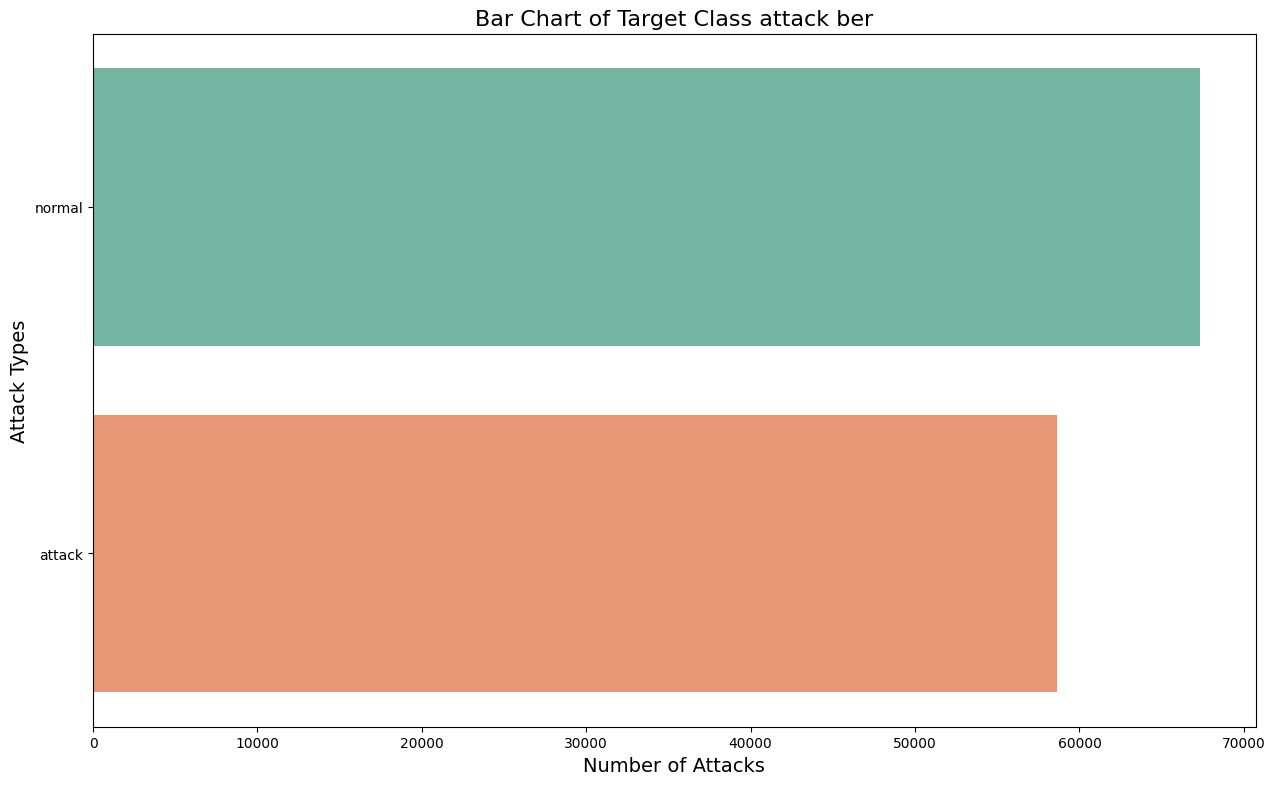

In [ ]:
df['attack'].loc[df['attack']!='normal']='attack'
target_col()

**LABEL ENCODING**

In [ ]:
le=LabelEncoder()

In [ ]:
df['protocoltype']=le.fit_transform(df['protocoltype'])
df['service']=le.fit_transform(df['service'])
df['flag']=le.fit_transform(df['flag'])
df['attack']=le.fit_transform(df['attack'])

# Assuming the LabelEncoder for 'protocoltype' has been fitted
protocoltype_le = LabelEncoder()
protocoltype_le.fit(df['protocoltype'])

# Save the classes of the encoder
np.save('protocoltype_classes.npy', protocoltype_le.classes_)

# Similarly, do the same for 'service' and 'flag'
service_le = LabelEncoder()
service_le.fit(df['service'])
np.save('service_classes.npy', service_le.classes_)

flag_le = LabelEncoder()
flag_le.fit(df['flag'])
np.save('flag_classes.npy', flag_le.classes_)


<Axes: >

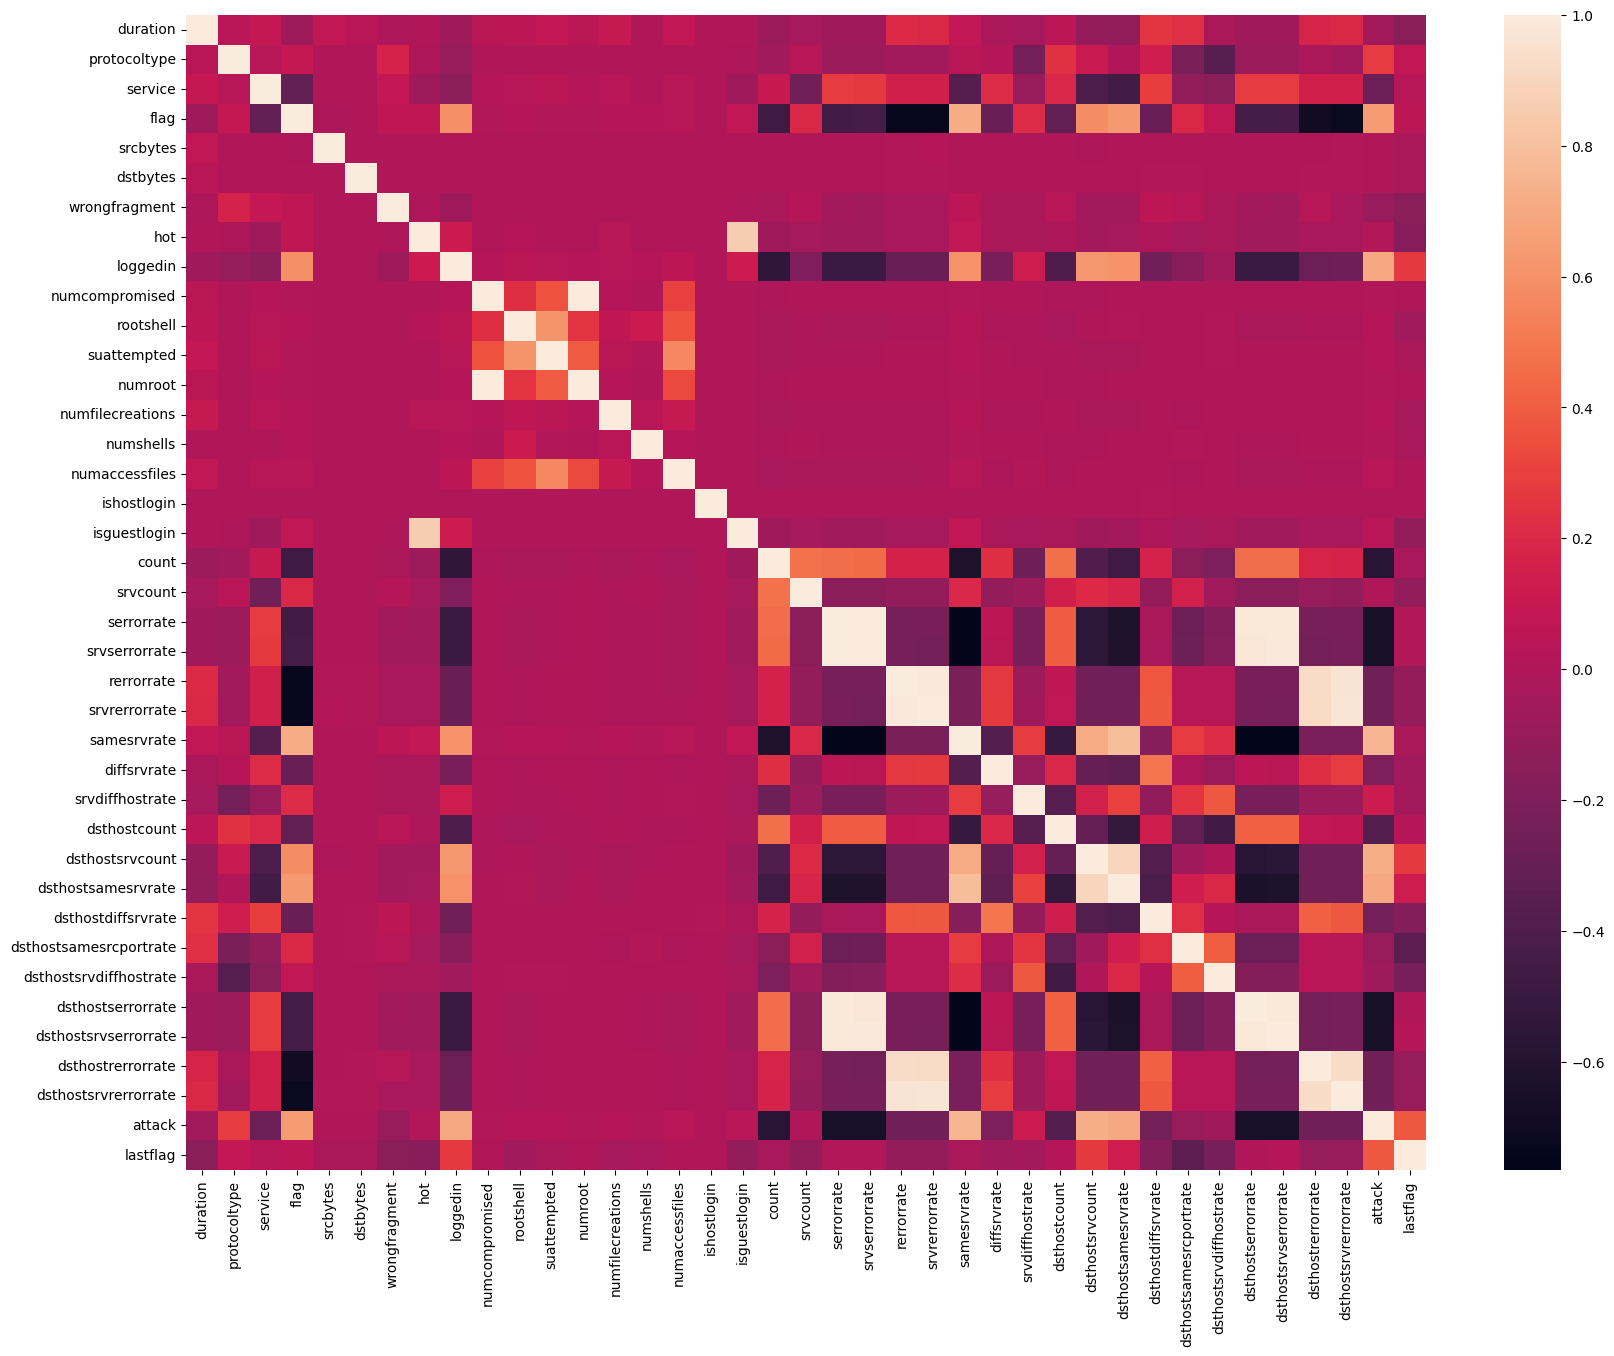

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr())

In [ ]:
#@title Feature selection
X = df.drop(['attack'],axis=1)
y =df['attack']

In [ ]:
y.unique()

array([1, 0])

In [ ]:
y

0         1
1         1
2         0
3         1
4         1
         ..
125968    0
125969    1
125970    1
125971    0
125972    1
Name: attack, Length: 125973, dtype: int64

In [ ]:
#sns.countplot(df['attack'])

In [ ]:
print("Class distribution: {}".format(Counter(y)))

Class distribution: Counter({1: 67343, 0: 58630})


**SCALLING**

In [ ]:
scaler = StandardScaler()
scaler.fit(X)


# Save mean and scale
np.save('scaler_mean.npy', scaler.mean_)
np.save('scaler_scale.npy', scaler.scale_)


X_transformed = scaler.transform(X)

**PREPROCESSING THE TEST SET**

In [ ]:
test_df = pd.read_csv("/content/data/Test.txt",sep=",",names=["duration","protocoltype","service","flag","srcbytes","dstbytes","land", "wrongfragment","urgent","hot","numfailedlogins","loggedin", "numcompromised","rootshell","suattempted","numroot","numfilecreations", "numshells","numaccessfiles","numoutboundcmds","ishostlogin",
"isguestlogin","count","srvcount","serrorrate", "srvserrorrate",
"rerrorrate","srvrerrorrate","samesrvrate", "diffsrvrate", "srvdiffhostrate","dsthostcount","dsthostsrvcount","dsthostsamesrvrate", "dsthostdiffsrvrate","dsthostsamesrcportrate",
"dsthostsrvdiffhostrate","dsthostserrorrate","dsthostsrvserrorrate",
"dsthostrerrorrate","dsthostsrvrerrorrate","attack", "lastflag"])
test_df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [ ]:
test_df.select_dtypes(exclude=[np.number])

,protocoltype,service,flag,attack
0,tcp,private,REJ,neptune
1,tcp,private,REJ,neptune
2,tcp,ftp_data,SF,normal
3,icmp,eco_i,SF,saint
4,tcp,telnet,RSTO,mscan
...,...,...,...,...
22539,tcp,smtp,SF,normal
22540,tcp,http,SF,normal
22541,tcp,http,SF,back
22542,udp,domain_u,SF,normal


In [ ]:
test_df['attack'].loc[test_df['attack']!='normal']='attack'

In [ ]:
test_df['protocoltype']=le.fit_transform(test_df['protocoltype'])
test_df['service']=le.fit_transform(test_df['service'])
test_df['flag']=le.fit_transform(test_df['flag'])
test_df['attack']=le.fit_transform(test_df['attack'])

In [ ]:
test_df.drop(['land','urgent','numfailedlogins','numoutboundcmds'],axis=1,inplace=True)

In [ ]:
X_test=test_df.drop(['attack'],axis=1)
y_test=test_df['attack']

In [ ]:
X_test.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,wrongfragment,hot,loggedin,numcompromised,...,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag
0,0,1,45,1,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,21
1,0,1,45,1,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,21
2,2,1,19,9,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,21
3,0,0,13,9,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,15
4,1,1,55,2,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,11


In [ ]:
X_test_transformed = scaler.transform(X_test)

### Training the Model

In [ ]:
lr=LogisticRegression()
lr.fit(X_transformed,y)

LogisticRegression()

**RFC**

In [ ]:
rf=RandomForestClassifier()
rf.fit(X_transformed,y)

RandomForestClassifier()

In [ ]:
#@title  Parameter grid for RandomForestClassifier
rf_param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}
# RandomForestClassifier GridSearchCV
rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=2, verbose=3, refit=True)
# Fit the model
rf_grid.fit(X_transformed,y)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=0.998 total time=   0.6s
[CV 2/2] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=0.998 total time=   0.5s
[CV 1/2] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.999 total time=   2.5s
[CV 2/2] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.999 total time=   2.6s
[CV 1/2] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=0.998 total time=   0.8s
[CV 2/2] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=0.999 total time=   0.8s
[CV 1/2] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.999 total time=   3.7s
[CV 2/2] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=0.999 total time=   2.5s

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 10],
                         'n_estimators': [10, 50]},
             verbose=3)

In [ ]:
# Retrieve the best estimators
best_rf_model = rf_grid.best_estimator_

In [ ]:
best_rf_model

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50)

**SVC**

In [ ]:
# Create and train the SVM model
svm_model = SVC()
svm_model.fit(X_transformed, y)

SVC()

In [ ]:
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter range
param_grid = {
    'C': [0.1, 1],
    'gamma': [0.01, 0.001]
}

# Initialize GridSearchCV object
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

# Fit the model for grid search using the training data
grid.fit(X_transformed, y)

# Retrieve the best estimator from GridSearchCV
best_Svc_model = grid.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.992 total time= 6.1min
[CV 2/5] END .................C=0.1, gamma=0.01;, score=0.992 total time= 1.5min
[CV 3/5] END .................C=0.1, gamma=0.01;, score=0.992 total time= 6.0min
[CV 4/5] END .................C=0.1, gamma=0.01;, score=0.992 total time= 6.1min
[CV 5/5] END .................C=0.1, gamma=0.01;, score=0.993 total time= 1.4min
[CV 1/5] END ................C=0.1, gamma=0.001;, score=0.975 total time= 8.1min
[CV 2/5] END ................C=0.1, gamma=0.001;, score=0.975 total time= 5.0min
[CV 3/5] END ................C=0.1, gamma=0.001;, score=0.975 total time= 5.0min
[CV 4/5] END ................C=0.1, gamma=0.001;, score=0.976 total time= 6.8min
[CV 5/5] END ................C=0.1, gamma=0.001;, score=0.975 total time=10.4min
[CV 1/5] END ...................C=1, gamma=0.01;, score=0.997 total time=  38.9s
[CV 2/5] END ...................C=1, gamma=0.01;,

**DEEP LEARNING**

**ANN model**

In [ ]:
from sklearn.neural_network import MLPClassifier
# Create and train the ANN model
ann_model = MLPClassifier()
ann_model.fit(X_transformed, y)

MLPClassifier()

In [ ]:
# Parameter grid for MLPClassifier
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

In [ ]:
# MLPClassifier GridSearchCV
mlp_grid = GridSearchCV(MLPClassifier(), mlp_param_grid, cv=3, verbose=3, refit=True)
mlp_grid.fit(X_transformed,y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant;, score=0.999 total time=  28.0s
[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant;, score=0.998 total time=  24.1s
[CV 3/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant;, score=0.999 total time=  24.9s
[CV 1/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive;, score=0.999 total time=  30.7s
[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive;, score=0.999 total time=  23.7s
[CV 3/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive;, score=0.999 total time=  27.6s
[CV 1/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant;, score=0.999 total time=  38.9s
[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer

GridSearchCV(cv=3, estimator=MLPClassifier(),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(50,), (100,)],
                         'learning_rate': ['constant', 'adaptive']},
             verbose=3)

In [ ]:
# Retrieve the best estimators
best_mlp_model = mlp_grid.best_estimator_

**LSTM**

In [ ]:
X_lstm = np.expand_dims(X_transformed, axis=1)

In [ ]:

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#@title Defining LSTM model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
    Dropout(0.2),  # Adding dropout for regularization
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),  # Last LSTM layer without return_sequences
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile model
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Print the architecture of the LSTM model
print("LSTM Model Architecture:")
print(lstm_model.summary())
# Train model
lstm_model.fit(X_lstm, y, epochs=20, batch_size=64, verbose=1)

LSTM Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            85504     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (N

In [ ]:
! pip install keras-tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras_tuner import Hyperband

# Define a function to create the LSTM model for tuning
def create_lstm_model(hp):
    model = Sequential([
        LSTM(hp.Int('lstm_units', min_value=50, max_value=200, step=50),
             input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
        Dense(1, activation='sigmoid')
    ])

    # Compile model with hyperparameters
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create a tuner using Hyperband
tuner = Hyperband(create_lstm_model,
                  max_epochs=20,  # Maximum number of epochs to train
                  objective='val_accuracy',  # Objective for tuning
                  factor=3,  # Hyperband factor
                  directory='lstm_tuning',  # Directory to save tuning results
                  project_name='lstm_hyperparameter_tuning')

# Perform the tuning
tuner.search(X_lstm, y, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
# Retrieve the best model
best_lstm_model = tuner.get_best_models(num_models=1)[0]

Trial 4 Complete [00h 00m 53s]
val_accuracy: 0.9978170394897461

Best val_accuracy So Far: 0.9978170394897461
Total elapsed time: 00h 03m 29s


### Predictions

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

def confusion_plot(actual, predicted):
  confusion_matrix = metrics.confusion_matrix(actual, predicted)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['attack', 'normal'])
  cm_display.plot()
  plt.show()

In [ ]:
#@title gobal fuction for prediction

import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import metrics

df_all = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score', 'Recall', 'Precision'])

def confusion_plot(actual, predicted):
    confusion_matrix_ = confusion_matrix(actual, predicted)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_, display_labels=['attack', 'normal'])
    cm_display.plot()
    plt.show()

def predictor_(x_test, y_test, model, model_name, df):
    pred = model.predict(x_test)
    accuracy_ = accuracy_score(y_test, pred)
    clas = classification_report(y_test, pred, output_dict=True)
    f1_score_ = clas['macro avg']['f1-score']
    recall_ = clas['macro avg']['recall']
    precision_ = clas['macro avg']['precision']
    confusion_plot(y_test, pred)

    # create df with the varible
    result_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_],
        'F1 Score': [f1_score_],
        'Recall': [recall_],
        'Precision': [precision_]
    })

    df_all = pd.concat([df, result_df])

    return df_all

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_deepmodel(model, X_test, y_test, model_name):
    # Reshape X_test for the model input
    X_test_input = np.expand_dims(X_test, axis=1)

    # Predict using the model
    model_pred = (model.predict(X_test_input) > 0.5).astype(int).flatten()

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, model_pred)
    precision = precision_score(y_test, model_pred)
    recall = recall_score(y_test, model_pred)
    f1 = f1_score(y_test, model_pred)

    # Classification report
    class_report = classification_report(y_test, model_pred)

    # Confusion matrix
    cm = confusion_plot(y_test, model_pred)

    # Store evaluation results in a dictionary
    evaluation_results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Model name": model_name
    }

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(evaluation_results, index=[0])

    # Print the classification report
    print(class_report)
    # Return the DataFrame containing evaluation results
    return df


**Using Logistic Regression**

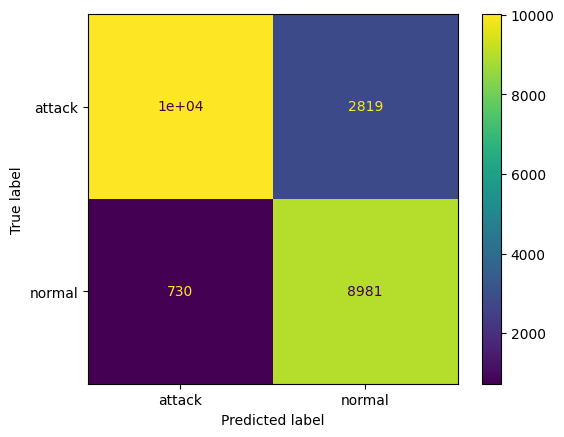

In [ ]:
lr_df = predictor_(X_test_transformed, y_test, lr, 'Logistic Regression', df_all)

In [ ]:
lr_df

,Model,Accuracy,F1 Score,Recall,Precision
0,Logistic Regression,0.842575,0.842243,0.85258,0.846578


In [ ]:
df_all

,Model,Accuracy,F1 Score,Recall,Precision


**Using Random Forest Classifier**

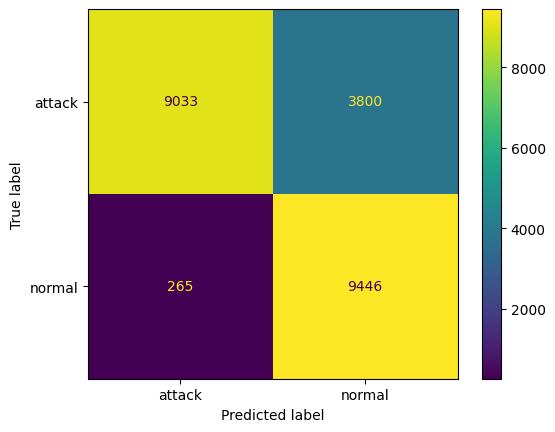

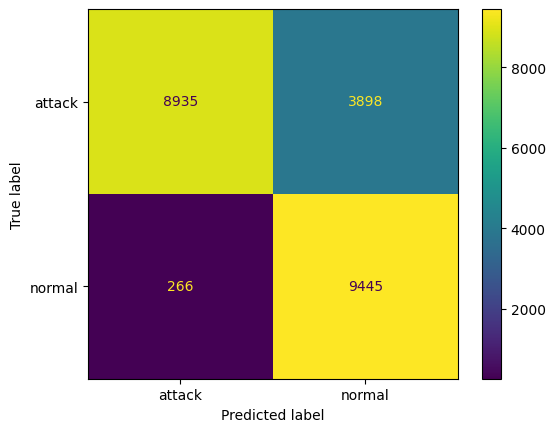

In [ ]:
rf_df = predictor_(X_test_transformed, y_test, rf, 'Random Forest Classifier Base model', lr_df)
rf_model = predictor_(X_test_transformed, y_test, best_rf_model, 'Random Forest Classifier fine tuned', rf_df)

In [ ]:
rf_model

,Model,Accuracy,F1 Score,Recall,Precision
0,Logistic Regression,0.842575,0.842243,0.85258,0.846578
0,Random Forest Classifier Base model,0.819686,0.819625,0.83830,0.842310
0,Random Forest Classifier fine tuned,0.815295,0.815200,0.83443,0.839476


**Support Vector machine**

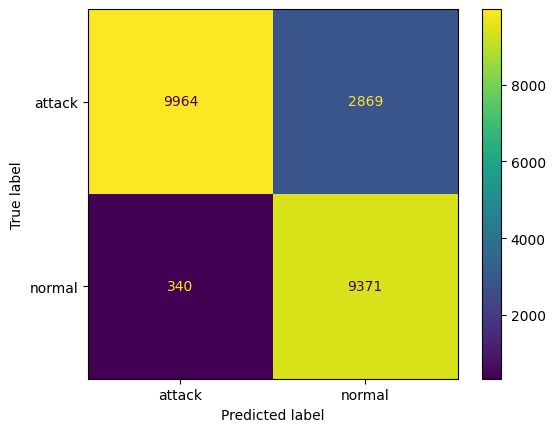

In [ ]:
svm_df = predictor_(X_test_transformed, y_test, svm_model, 'Support Vector machine base model', df_all)

In [ ]:
svm_df

,Model,Accuracy,F1 Score,Recall,Precision
0,Support Vector machine base model,0.857656,0.857558,0.870712,0.866304


In [ ]:
Svc_model_df = predictor_(X_test_transformed, y_test, best_Svc_model, 'Support Vector machine fine tuned', df_all)

In [ ]:
Svc_model_df

**Artificial Neural Network (ANN)**

In [ ]:
# Make predictions on the test set
ann_pd = predictor_(X_test_transformed, y_test, ann_model, 'ANN Base model', df_all)
ann_pd

In [ ]:
best_ann_pd = predictor_(X_test_transformed, y_test, best_mlp_model, 'ANN fine tuned', df_all)
best_ann_pd

**Using LSTM**

In [ ]:
evaluation_df = evaluate_deepmodel(lstm_model, X_test_transformed, y_test, "LSTM Base")
evaluation_df

**with tuning Lstm**

In [ ]:
evaluation_df_tune = evaluate_deepmodel(best_lstm_model, X_test_transformed, y_test, "LSTM Tuned")
evaluation_df_tune

In [ ]:
# Save the best LSTM model
best_lstm_model.save('best_lstm_model.h5')